In [1]:
import pyrealsense2 as rs
import numpy as np
import cv2
from utilites import *
import apriltag
import matplotlib.pyplot as plt
from D435i import D435i

In [6]:
myD435i = D435i(families='tag36h11')

while True:
    _, color_image = myD435i.get_image()
    gray_img = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
    tags = myD435i.get_tags(gray_img)
    color_image = draw_tags_box(tags, color_image)
    print(tags)

    cv2.imshow('RealSense Color', color_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
myD435i.stop_pipline()
cv2.destroyAllWindows()
    

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[Detection(tag_family=b'tag36h11', tag_id=1, hamming=0, goodness=0.0, decision_margin=71.09144592285156, homography=array([[-5.94265798e-01, -1.79772770e-01,  5.75932696e+00],
       [ 1.36901250e-01, -7.34855351e-01,  2.80331654e+00],
       [ 2.54091291e-04, -2.39308750e-04,  1.02325813e-02]]), center=array([562.84204434, 273.95986104]), corners=array([[639.41027832, 332.87704468],
       [498.30722046, 342.6328125 ],
       [486.49472046, 215.21266174],
       [633.91571045, 198.32878113]]))]
[Detection(tag_family=b'tag36h11', tag_id=1, hamming=0, goodness=0.0, decision_margin=70.99422454833984, homography=array([[ 5.96561479e-01,  1.69537046e-01, -5.71177699e+00],
       [-1.31997650e-01,  7.32554979e-01, -2.76713482e+00],
       [-2.50218308e-04,  2.28226947e-04, -1.02114675e-02]]), center=array([559.3492781 , 270.98307009]), corners=array([[635.74176025, 330.50689697],
       [49

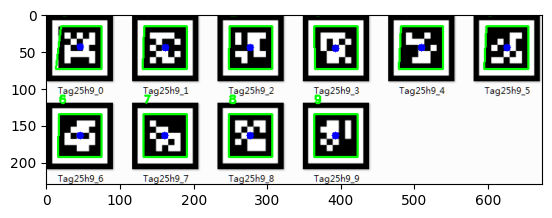

In [2]:
frame = cv2.imread('apriltag.png')
detect = detector(families='tag25h9')
gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
tags = get_tags(detect, gray_img)
frame = draw_tags_box(tags, frame)
plt.imshow(frame)

In [10]:
# pipeline.start(config)
frames = pipeline.wait_for_frames()
depth_frame = frames.get_depth_frame()
depth_image = np.asanyarray(depth_frame.get_data())
print(depth_image.shape)

(480, 640)


In [14]:
homography=np.array([[-5.63883522e-01, -4.47734408e-01, -1.93054772e+00],
                     [ 4.35035775e-01, -4.32272755e-01, -2.45711029e+00],
                     [-2.28876529e-04,  1.71351888e-04, -7.36692500e-03]])

In [7]:
tags

[Detection(tag_family=b'tag36h11', tag_id=1, hamming=0, goodness=0.0, decision_margin=65.88518524169922, homography=array([[-6.66065073e-01, -1.57823661e-01,  4.20335003e+00],
        [ 8.41265571e-02, -7.65526230e-01,  2.85069092e+00],
        [ 1.55650348e-04, -2.96972623e-04,  8.88967494e-03]]), center=array([472.8350652, 320.6743706]), corners=array([[556.66485596, 391.10748291],
        [395.52459717, 396.08496094],
        [386.296875  , 247.96568298],
        [558.44049072, 237.17266846]]))]

In [11]:
tag = tags[0]

In [15]:
corners = tag.corners
a = corners.sum(axis = 0)
b = a / 4
print(b)

[474.23170471 318.08269882]
